## 基于GP自动构造特征优化决策树交叉验证损失
在机器学习领域，特征工程是非常重要的一环。特征工程的目标是构造出对于机器学习算法来说更加有用的特征，以提高模型的性能。特征工程的方法有很多，包括但不限于：
* 核方法：将原始特征映射到更高维的特征空间，以便更容易地进行分类或回归。要求基础模型必须存在内积运算。
* 神经网络：使用神经网络来构造新特征。要求基础模型必须可导。

本文则重点关注遗传编程，即使用遗传编程（GP）来构造新特征。遗传编程是一种进化算法，它通过模拟自然选择的过程来优化问题的解。
在遗传编程中，每个解都是一个程序，程序的输入是原始特征，输出是新特征。遗传编程通过不断地进化，来寻找最优的特征构造程序。

### 遗传编程优势
**无梯度优化：相比核方法和神经网络，遗传编程的优势在于它能够优化交叉验证误差，以及任意基础学习模型，而不是直接优化训练误差，以及必须要求可导模型。这意味着遗传编程能够更好地避免过拟合，同时具有更好灵活性。**

**符号表示：相比核方法和神经网络，遗传编程基于符号表示，这意味着构造出的特征具有非常好的可解释性。**

**种群优化：分布式搜索，可以线性扩展到集群上。（注：神经网络的局部最优曾经被认为是一个问题，目前越来越多的研究表明神经网络的大部分Critical Point是鞍点。）**

### 为什么不使用神经网络？
#### 决策树->不可微分->无法使用神经网络构造特征
![决策树](img/DT.png)

#### 交叉验证误差->不可微分->无法使用梯度下降优化
![交叉验证误差](img/CV.png)

#### 传统神经网络->难以解释/内存占用高
![大模型](img/NN.png)

#### 梯度优化->难以大规模并行
![局部最优](img/Parallel.png)


### 评估函数
如上文所述，遗传编程的目标是优化交叉验证误差，而不像传统的特征工程方法那样优化训练误差。
值得一提的是，这里的交叉验证误差是在训练集上的交叉验证误差，而不是在测试集上的误差。

In [420]:
from gplearn.functions import _protected_division
from sklearn.datasets import load_iris, load_diabetes, load_breast_cancer, load_digits, load_wine
from sklearn.metrics import r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# 假设我们有一个回归问题，输入为X，输出为y
X, y = load_diabetes(return_X_y=True)
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2, random_state=0)
scaler = StandardScaler()
train_X = scaler.fit_transform(train_X)
test_X = scaler.transform(test_X)


# 求解问题的目标是最大化回归交叉验证分数
def evalFeatureEngineering(individuals):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 使用决策树进行回归
    model = DecisionTreeRegressor(min_samples_leaf=10)

    # 使用交叉验证计算误差
    scores = cross_val_score(model, new_features, train_y, cv=5)

    # 返回平均分数
    return scores.mean(),

### 多树GP个体表示
对于特征构造，每个GP个体可以是一个Tree列表，即一个个体包含多个特征，每个Tree代表一个新特征。

In [421]:
import operator
import random
import numpy as np
from deap import base, creator, tools, gp, algorithms
from sklearn.tree import DecisionTreeRegressor

np.random.seed(0)
random.seed(0)

def _protected_division(x1, x2):
    """Closure of division (x1/x2) for zero denominator."""
    with np.errstate(divide='ignore', invalid='ignore'):
        return np.where(np.abs(x2) > 0.001, np.divide(x1, x2), 1.)


# 创建GP框架的基本组件
pset = gp.PrimitiveSet("MAIN", X.shape[1])
pset.addPrimitive(np.add, 2)
pset.addPrimitive(np.subtract, 2)
pset.addPrimitive(np.multiply, 2)
pset.addPrimitive(_protected_division, 2)
pset.addEphemeralConstant("rand101", lambda: random.random() * 2 - 1)

# 创建一个适应度类和个体类，个体由多棵树组成
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

C:\Users\zhenl\anaconda3\Lib\site-packages\deap\gp.py:254: RuntimeWarning: Ephemeral rand101 function cannot be pickled because its generating function is a lambda function. Use functools.partial instead.
  warnings.warn("Ephemeral {name} function cannot be "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\zhenl\anaconda3\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


### 交叉/变异算子
对于多树GP，很明显我们还需要自己定义交叉和变异算子。这里我们对DEAP中的交叉和变异算子进行简单包装，将其改造成能够处理多棵树的列表结构的算子。

In [422]:
toolbox = base.Toolbox()
toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=1, max_=6)


# 初始化每个个体为一个包含多棵树的列表
def initIndividual(container, func, size):
    return container(gp.PrimitiveTree(func()) for _ in range(size))


# 交叉和变异算子需要能够处理列表结构
def cxOnePointListOfTrees(ind1, ind2):
    for tree1, tree2 in zip(ind1, ind2):
        gp.cxOnePoint(tree1, tree2)
    return ind1, ind2


def mutUniformListOfTrees(individual, expr, pset):
    for tree in individual:
        gp.mutUniform(tree, expr=expr, pset=pset)
    return individual,


toolbox.register("individual", initIndividual, creator.Individual, toolbox.expr, size=3)  # 假设我们创建3个特征
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("evaluate", evalFeatureEngineering)
toolbox.register("select", tools.selTournament, tournsize=5)
toolbox.register("mate", cxOnePointListOfTrees)
toolbox.register("mutate", mutUniformListOfTrees, expr=toolbox.expr, pset=pset)
toolbox.register("compile", gp.compile, pset=pset)

最后，演化流程与传统的GP算法没有区别。直接运行即可。

In [423]:
# 运行遗传编程算法
population = toolbox.population(n=100)
hof = tools.HallOfFame(1)

# 统计和日志
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=stats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)


gen	nevals	avg       	std     	min      	max     
0  	100   	-0.0352535	0.184681	-0.465253	0.408738
1  	93    	0.0644668 	0.184211	-0.401944	0.42935 
2  	95    	0.164617  	0.176327	-0.345223	0.453795
3  	87    	0.257854  	0.123272	-0.185119	0.453795
4  	94    	0.275092  	0.13214 	-0.228863	0.425609
5  	84    	0.304867  	0.110798	-0.0778575	0.427339
6  	88    	0.292916  	0.144577	-0.315127 	0.437872
7  	89    	0.301983  	0.151803	-0.380469 	0.439317
8  	91    	0.321926  	0.131414	-0.234202 	0.454113
9  	98    	0.326328  	0.136062	-0.246197 	0.45335 
10 	86    	0.303931  	0.143638	-0.185107 	0.45335 
Best individual is: ['subtract(ARG5, subtract(ARG0, ARG7))', 'add(ARG8, ARG2)', 'add(ARG1, ARG1)']
With fitness: (0.45411339055004607,)


In [424]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_predictions(train_y, predicted_train_y, test_y, predicted_y, name):
    training_r2 = r2_score(train_y, predicted_train_y)
    r2 = r2_score(test_y, predicted_y)
    sns.set_style("whitegrid")
    plt.scatter(test_y, predicted_y)
    plt.plot([min(test_y), max(test_y)], [min(test_y), max(test_y)], linestyle='--')
    plt.xlabel('True Values')
    plt.ylabel('Predicted Values')
    plt.title(f'{name} Training R² Score: {training_r2:.3f} \n Test R² Score: {r2:.3f}')
    plt.show()

### 评估最佳个体在测试集上的性能
对于最佳个体，我们可以使用它构造的新特征来训练模型，并使用该特征转换测试集，然后评估模型在测试集上的性能。

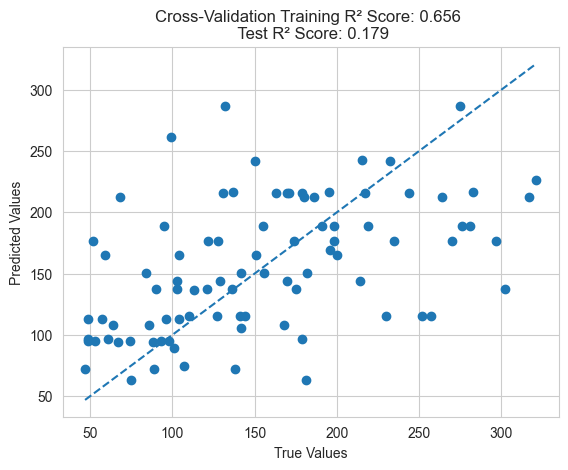

0.17898444441640715

In [425]:
def evaluationOnTest(trees, name):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(trees):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))
    model = DecisionTreeRegressor(min_samples_leaf=10)
    model.fit(new_features, train_y)
    train_y_pred = model.predict(new_features)

    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(trees):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in test_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 返回训练误差
    score = r2_score(test_y, model.predict(new_features))
    plot_predictions(train_y, train_y_pred, test_y, model.predict(new_features), name)
    return score


evaluationOnTest(best_ind, "Cross-Validation")

### 直接优化训练误差的GP
当然，我们也可以使用遗传编程来优化训练误差。

gen	nevals	avg     	std     	min      	max    
0  	0     	0.303931	0.143638	-0.185107	0.45335
1  	88    	0.55985 	0.0987481	0.256506 	0.665762
2  	90    	0.590953	0.0693942	0.267409 	0.682302
3  	86    	0.605792	0.070243 	0.310435 	0.676585
4  	92    	0.599634	0.0660101	0.379885 	0.685347
5  	89    	0.596156	0.0815029	0.301172 	0.684787
6  	94    	0.592179	0.0792609	0.291761 	0.676509
7  	86    	0.599535	0.082606 	0.276139 	0.67517 
8  	89    	0.614152	0.0673441	0.376966 	0.699104
9  	91    	0.593205	0.0781903	0.229489 	0.680216
10 	85    	0.608815	0.0651021	0.336586 	0.684946
Best individual is: ['subtract(ARG0, add(ARG1, ARG2))', 'add(ARG8, ARG2)', 'add(subtract(add(ARG6, ARG6), multiply(add(ARG9, ARG0), ARG3)), multiply(ARG6, add(ARG6, ARG0)))']
With fitness: (0.6991039640945576,)


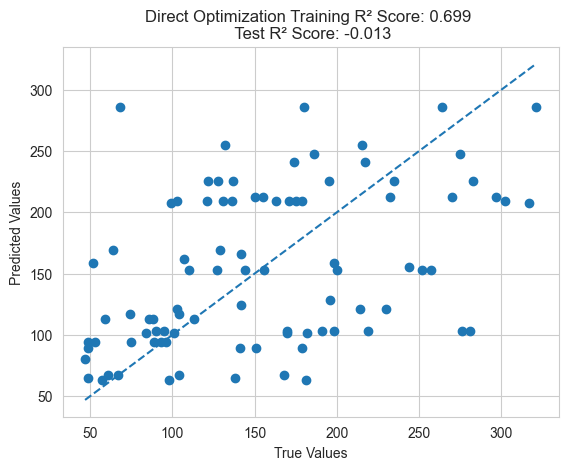

-0.013256758248239464

In [426]:
def evalFeatureEngineeringTrainingError(individuals):
    # 创建新特征
    new_features = []
    for ind_num, ind in enumerate(individuals):
        func = gp.compile(expr=ind, pset=pset)
        new_features.append([func(*record) for record in train_X])

    # 转置新特征数组
    new_features = np.transpose(np.array(new_features))

    # 使用决策树进行回归
    model = DecisionTreeRegressor(min_samples_leaf=10)
    model.fit(new_features, train_y)

    # 返回训练误差
    return r2_score(train_y, model.predict(new_features)),


toolbox.register("evaluate", evalFeatureEngineeringTrainingError)

pop, log = algorithms.eaSimple(population, toolbox, 0.9, 0.1, 10, stats=stats, halloffame=hof, verbose=True)

# 查看最佳个体
best_ind = hof[0]
print('Best individual is:', [str(tree) for tree in best_ind])
print('With fitness:', best_ind.fitness.values)
evaluationOnTest(best_ind, "Direct Optimization")

### 传统特征工程方法
最后，我们可以使用传统的特征工程方法，例如神经网络和Kernel方法来构造新特征，然后训练模型，看看它们的性能如何。

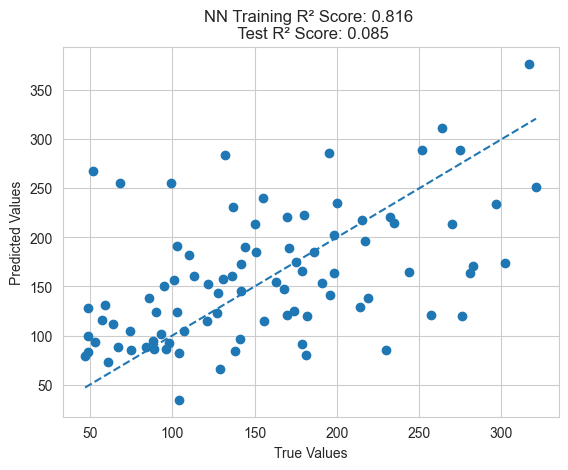

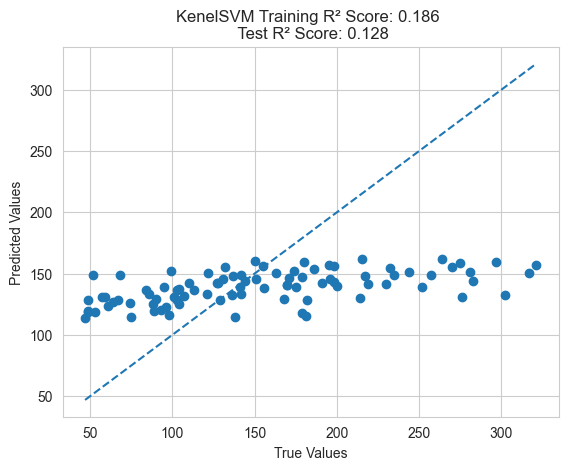

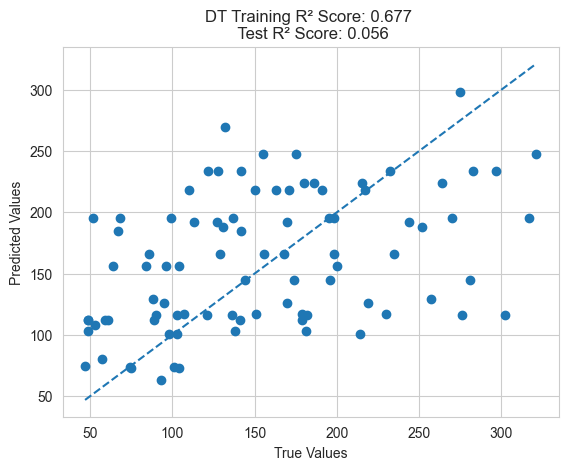

In [427]:
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR

# 使用神经网络
model = MLPRegressor(learning_rate_init=0.01, max_iter=10000)
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "NN")

# 使用核SVM
model = SVR()
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "KenelSVM")

# 使用决策树
model = DecisionTreeRegressor(min_samples_leaf=10)
model.fit(train_X, train_y)
plot_predictions(train_y, model.predict(train_X), test_y, model.predict(test_X), "DT")

从上面的结果可以看出，遗传编程的特征工程方法在测试集上的性能要优于传统的特征工程方法。验证了GP的优势。
另外，特别重要的是，遗传编程特征工程方法优化交叉验证误差，而不是直接优化训练误差，导致了其更好的泛化性能。
如果直接优化训练误差，则会导致过拟合，不能很好地泛化到测试集上。
